# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.

---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  
- If a dog is detected in the image, it will provide an estimate of the dog's breed.  
- If a human is detected, it will provide an estimate of the dog breed that is most resembling.  

The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](https://gitlab.com/atlonxp/dog-breeds-classification/-/raw/master/images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

---
### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets and Clone project

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
#!git clone https://gitlab.com/atlonxp/dog-breeds-classification.git
%cd dog-breeds-classification

[WinError 2] The system cannot find the file specified: 'dog-breeds-classification'
c:\Users\User\Downloads\dog_app\dog-breeds-classification


In [2]:
# Download datasets
!wget -q https://gitlab.com/atlonxp/siit-deep-learning/-/raw/main/dogImages.zip -O dogImages.zip
!wget -q https://gitlab.com/atlonxp/siit-deep-learning/-/raw/main/lfw.zip -O lfw.zip

# Download pretrained vgg16
!wget -q https://gitlab.com/atlonxp/siit-deep-learning/-/raw/main/DogVGG16Data.npz -O bottleneck_features/DogVGG16Data.npz

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# Unzip datasets
!unzip -qq dogImages.zip
!unzip -qq lfw.zip
!rm -rf __MACOSX/

'unzip' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
from sklearn.datasets import load_files       
from tensorflow.keras import utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [4]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


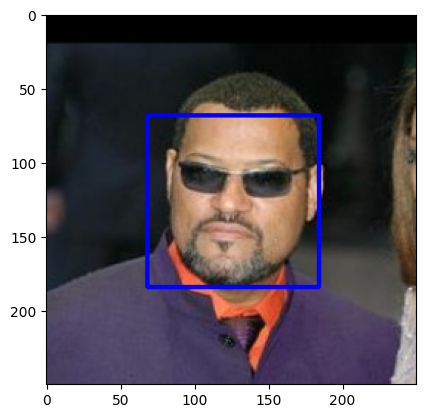

In [5]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### **(IMPLEMENTATION)** Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [7]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.
# Test the face_detector on human images
human_face_count = sum(face_detector(img) for img in human_files_short)
print(f'Percentage of human faces detected in human_files_short: {human_face_count}%')

# Test the face_detector on dog images
dog_face_count = sum(face_detector(img) for img in dog_files_short)
print(f'Percentage of dog faces detected in dog_files_short: {dog_face_count}%')

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

Percentage of human faces detected in human_files_short: 99%
Percentage of dog faces detected in dog_files_short: 12%


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [9]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [8]:
from tensorflow.keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [10]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### **(IMPLEMENTATION)** Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [12]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
# Test the face_detector on human images
human_face_count = sum(dog_detector(img) for img in human_files_short)
print(f'Percentage of human faces detected in human_files_short: {human_face_count}%')

# Test the face_detector on dog images
dog_face_count = sum(dog_detector(img) for img in dog_files_short)
print(f'Percentage of dog faces detected in dog_files_short: {dog_face_count}%')


1/1 [==============================] - 0s 65ms/step
Percentage of human faces detected in human_files_short: 0%
1/1 [==============================] - 0s 67ms/step
Percentage of dog faces detected in dog_files_short: 100%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="https://gitlab.com/atlonxp/dog-breeds-classification/-/raw/master/images/Brittany_02625.jpg" width="100"> | <img src="https://gitlab.com/atlonxp/dog-breeds-classification/-/raw/master/images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="https://gitlab.com/atlonxp/dog-breeds-classification/-/raw/master/images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="https://gitlab.com/atlonxp/dog-breeds-classification/-/raw/master/images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="https://gitlab.com/atlonxp/dog-breeds-classification/-/raw/master/images/Labrador_retriever_06457.jpg" width="150"> | <img src="https://gitlab.com/atlonxp/dog-breeds-classification/-/raw/master/images/Labrador_retriever_06455.jpg" width="240"> | <img src="https://gitlab.com/atlonxp/dog-breeds-classification/-/raw/master/images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:09<00:00, 91.50it/s] 


### **(IMPLEMENTATION)** Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](https://github.com/udacity/dog-project/raw/master/images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
# 4 Convolutional layers for the depth complexity of the tasks and 4 max pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
# 4 Max pooling to down sample the image to reduce the spatial volume
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# Convolutional layers is increased in depth for the complexity of dog breeds classification
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# GlobalAveragePooling2D() performs an average pooling operation, reducing the spatial dimensions.
model.add(GlobalAveragePooling2D())

# 512 Unit layer is deep enough for complexity and it avoids overfitting
model.add(Dense(512, activation='relu'))

# Incase of overfitting we add dropout of 0.5
model.add(Dropout(0.5))

# Softmax because it's for various multi-class classification
model.add(Dense(133, activation='softmax'))  # Output layer with the number of classes

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

### Compile the Model

In [18]:
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

### **(IMPLEMENTATION)** Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/5
334/334 [==============================] - ETA: 0s - loss: 4.8723 - accuracy: 0.0121
Epoch 1: val_loss improved from inf to 4.77729, saving model to saved_models\weights.best.from_scratch.hdf5
334/334 [==============================] - 99s 292ms/step - loss: 4.8723 - accuracy: 0.0121 - val_loss: 4.7773 - val_accuracy: 0.0240


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/5
334/334 [==============================] - ETA: 0s - loss: 4.7051 - accuracy: 0.0223
Epoch 2: val_loss improved from 4.77729 to 4.56425, saving model to saved_models\weights.best.from_scratch.hdf5
334/334 [==============================] - 91s 274ms/step - loss: 4.7051 - accuracy: 0.0223 - val_loss: 4.5643 - val_accuracy: 0.0407
Epoch 3/5
334/334 [==============================] - ETA: 0s - loss: 4.4918 - accuracy: 0.0404
Epoch 3: val_loss improved from 4.56425 to 4.43462, saving model to saved_models\weights.best.from_scratch.hdf5
334/334 [==============================] - 94s 283ms/step - loss: 4.4918 - accuracy: 0.0404 - val_loss: 4.4346 - val_accuracy: 0.0611
Epoch 4/5
334/334 [==============================] - ETA: 0s - loss: 4.1965 - accuracy: 0.0759
Epoch 4: val_loss improved from 4.43462 to 4.27709, saving model to saved_models\weights.best.from_scratch.hdf5
334/334 [==============================] - 91s 274ms/step - loss: 4.1965 - accuracy: 0.0759 - val_loss: 4.2771 

### Load the Model with the Best Validation Loss

In [20]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [21]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(dog_breed_predictions) == np.argmax(test_targets, axis=1)) / len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
Test accuracy: 6.3397%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds - Transfer Learning with VGG16

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [22]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [23]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 133)               68229     
                                                                 
Total params: 68229 (266.52 KB)
Trainable params: 68229 (266.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compile the Model

In [24]:
VGG16_model.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy']
)

### Train the Model

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
258/334 [======================>.......] - ETA: 0s - loss: 8.4634 - accuracy: 0.1886 

302/334 [==========================>...] - ETA: 0s - loss: 7.8046 - accuracy: 0.2199
Epoch 1: val_loss improved from inf to 3.69030, saving model to saved_models\weights.best.VGG16.hdf5
334/334 [==============================] - 1s 2ms/step - loss: 7.3835 - accuracy: 0.2443 - val_loss: 3.6903 - val_accuracy: 0.4623
Epoch 2/20
301/334 [==========================>...] - ETA: 0s - loss: 2.1511 - accuracy: 0.6038
Epoch 2: val_loss improved from 3.69030 to 2.66613, saving model to saved_models\weights.best.VGG16.hdf5
334/334 [==============================] - 0s 1ms/step - loss: 2.1175 - accuracy: 0.6102 - val_loss: 2.6661 - val_accuracy: 0.5820
Epoch 3/20
301/334 [==========================>...] - ETA: 0s - loss: 1.1953 - accuracy: 0.7490
Epoch 3: val_loss improved from 2.66613 to 2.31401, saving model to saved_models\weights.best.VGG16.hdf5
334/334 [==============================] - 0s 1ms/step - loss: 1.2067 - accuracy: 0.7490 - val_loss: 2.3140 - val_accuracy: 0.6251
Epoch 4/20
309/334 

### Load the Model with the Best Validation Loss

In [26]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [27]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Test accuracy: 72.7273%


### Predict Dog Breed with the Model

In [28]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]


---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds using Transfer Learning

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://gitlab.com/atlonxp/siit-deep-learning/-/raw/main/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://gitlab.com/atlonxp/siit-deep-learning/-/raw/main/DogResnet50Data.npz) bottleneck features
- [Inception](https://gitlab.com/atlonxp/siit-deep-learning/-/raw/main/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://gitlab.com/atlonxp/siit-deep-learning/-/raw/main/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### **(IMPLEMENTATION)** Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [15]:
# Download pre-trained CNN model, pick one
# VGG19 | Resnet50 | InceptionV3 | Xception
network = "DogResnet50Data"
!wget -q https://gitlab.com/atlonxp/siit-deep-learning/-/raw/main/$network -O bottleneck_features/$network

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [16]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load(f'bottleneck_features/{network}.npz')
train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']

### **(IMPLEMENTATION)** Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [17]:
### TODO: Define your architecture.
ResNet50_model = Sequential()
ResNet50_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
ResNet50_model.add(Dense(133, activation='softmax'))

ResNet50_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 133)               272517    
                                                                 
Total params: 272517 (1.04 MB)
Trainable params: 272517 (1.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### **(IMPLEMENTATION)** Compile the Model

In [18]:
### TODO: Compile the model.
ResNet50_model.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy']
)

### **(IMPLEMENTATION)** Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint  
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

ResNetHistory = ResNet50_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
322/334 [===========================>..] - ETA: 0s - loss: 1.6635 - accuracy: 0.5919
Epoch 1: val_loss improved from inf to 0.83259, saving model to saved_models\weights.best.ResNet50.hdf5
334/334 [==============================] - 2s 3ms/step - loss: 1.6356 - accuracy: 0.5975 - val_loss: 0.8326 - val_accuracy: 0.7485
Epoch 2/20
 39/334 [==>...........................] - ETA: 0s - loss: 0.4247 - accuracy: 0.8628

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


331/334 [============================>.] - ETA: 0s - loss: 0.4381 - accuracy: 0.8622
Epoch 2: val_loss improved from 0.83259 to 0.70609, saving model to saved_models\weights.best.ResNet50.hdf5
334/334 [==============================] - 1s 3ms/step - loss: 0.4384 - accuracy: 0.8626 - val_loss: 0.7061 - val_accuracy: 0.7832
Epoch 3/20
330/334 [============================>.] - ETA: 0s - loss: 0.2569 - accuracy: 0.9191
Epoch 3: val_loss improved from 0.70609 to 0.68388, saving model to saved_models\weights.best.ResNet50.hdf5
334/334 [==============================] - 1s 3ms/step - loss: 0.2570 - accuracy: 0.9189 - val_loss: 0.6839 - val_accuracy: 0.7916
Epoch 4/20
328/334 [============================>.] - ETA: 0s - loss: 0.1736 - accuracy: 0.9465
Epoch 4: val_loss improved from 0.68388 to 0.64375, saving model to saved_models\weights.best.ResNet50.hdf5
334/334 [==============================] - 1s 3ms/step - loss: 0.1736 - accuracy: 0.9463 - val_loss: 0.6438 - val_accuracy: 0.8072
Epoch 

### **(IMPLEMENTATION)** Load the Model with the Best Validation Loss

In [20]:
### TODO: Load the model weights with the best validation loss.
ResNet50_model.load_weights('saved_models/weights.best.ResNet50.hdf5')

### **(IMPLEMENTATION)** Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [21]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
ResNet50_predictions = [np.argmax(ResNet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 15ms/step
Test accuracy: 82.7751%


### **(IMPLEMENTATION)** Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [22]:
def ResNet50_predict_breed(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    prediction = ResNet50_model.predict(x)
    decoded_predictions = decode_predictions(prediction, top=1)
    return decoded_predictions[0][0][1]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](https://gitlab.com/atlonxp/dog-breeds-classification/-/raw/master/images/sample_human_output.png)


### **(IMPLEMENTATION)** Write your Algorithm

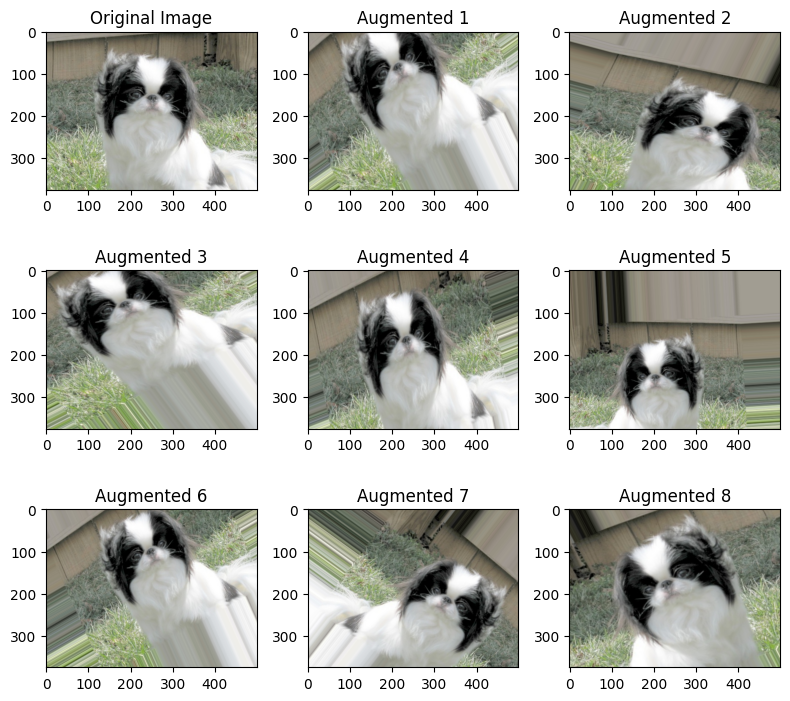

In [16]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# Load an example image
img = load_img('dogImages/train/091.Japanese_chin/Japanese_chin_06159.jpg')
x = img_to_array(img)

# Generate and display augmented images in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

plt.subplots_adjust(wspace=2)

for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.imshow(array_to_img(x))
        ax.set_title('Original Image')
    else:
        batch = datagen.flow(x.reshape(1, *x.shape), batch_size=1)
        augmented_image = array_to_img(batch[0][0])
        ax.imshow(augmented_image)
        ax.set_title(f'Augmented {i}')

plt.tight_layout()
plt.show()

In [54]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64 , kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133,activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 16)      208       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 28, 28, 64)       

In [17]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'dogImages/train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical') 

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'dogImages/valid',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


In [57]:
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [58]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.bestest_model.hdf5', 
                               verbose=1, save_best_only=True)

# Model with augmented data
history = model.fit(train_generator,
    validation_data=(validation_generator),
    epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

# model.fit(train_tensors, train_targets, 
#           validation_data=(valid_tensors, valid_targets),
#           epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
418/418 [==============================] - ETA: 0s - loss: 11.6838 - accuracy: 0.0096
Epoch 1: val_loss improved from inf to 4.88481, saving model to saved_models\weights.best.bestest_model.hdf5
418/418 [==============================] - 110s 260ms/step - loss: 11.6838 - accuracy: 0.0096 - val_loss: 4.8848 - val_accuracy: 0.0096
Epoch 2/20


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


418/418 [==============================] - ETA: 0s - loss: 4.8670 - accuracy: 0.0126
Epoch 2: val_loss improved from 4.88481 to 4.88049, saving model to saved_models\weights.best.bestest_model.hdf5
418/418 [==============================] - 96s 229ms/step - loss: 4.8670 - accuracy: 0.0126 - val_loss: 4.8805 - val_accuracy: 0.0108
Epoch 3/20
418/418 [==============================] - ETA: 0s - loss: 4.8041 - accuracy: 0.0159
Epoch 3: val_loss improved from 4.88049 to 4.87745, saving model to saved_models\weights.best.bestest_model.hdf5
418/418 [==============================] - 96s 231ms/step - loss: 4.8041 - accuracy: 0.0159 - val_loss: 4.8775 - val_accuracy: 0.0144
Epoch 4/20
418/418 [==============================] - ETA: 0s - loss: 4.7638 - accuracy: 0.0181
Epoch 4: val_loss improved from 4.87745 to 4.85924, saving model to saved_models\weights.best.bestest_model.hdf5
418/418 [==============================] - 97s 231ms/step - loss: 4.7638 - accuracy: 0.0181 - val_loss: 4.8592 - val

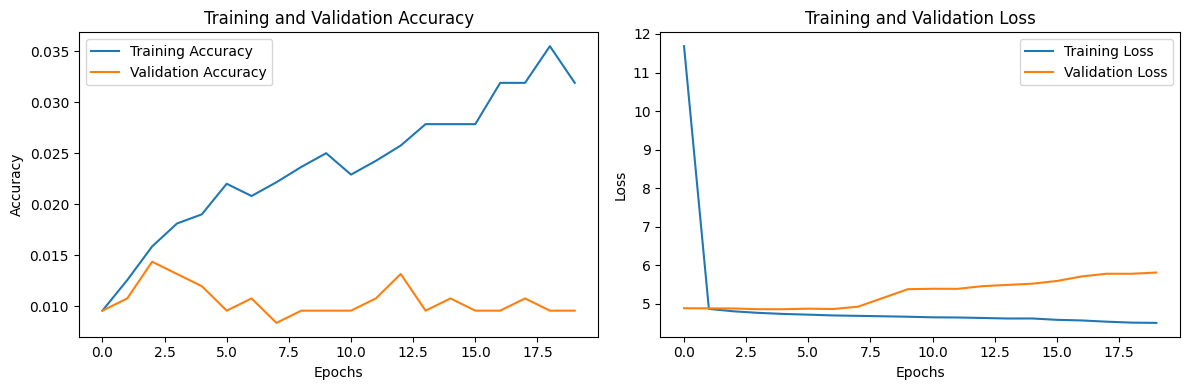

In [59]:
import matplotlib.pyplot as plt

# Access the training history from the `history` object
history_dict = history.history

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

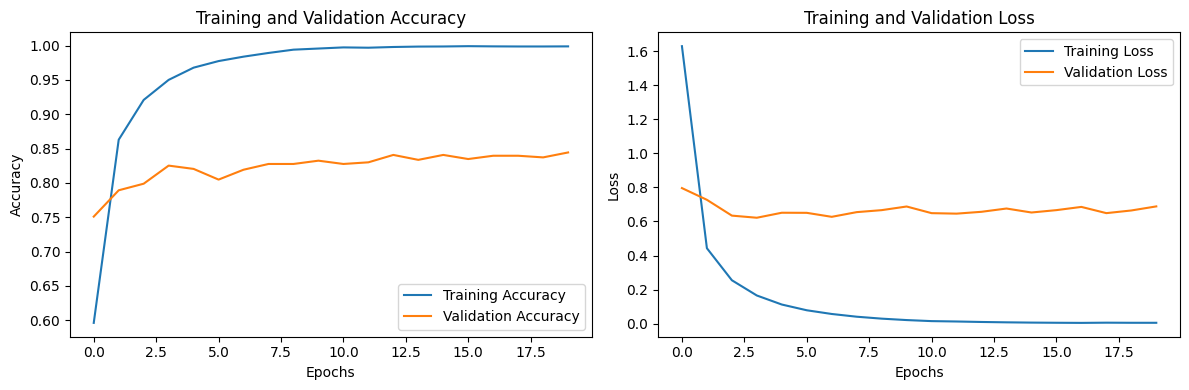

In [ ]:
import matplotlib.pyplot as plt

# Graphs for ResNet50 Dog breed model
# Access the training history from the `history` object
ResNet_history = ResNetHistory.history

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(ResNet_history['accuracy'], label='Training Accuracy')
plt.plot(ResNet_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(ResNet_history['loss'], label='Training Loss')
plt.plot(ResNet_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.load_weights('saved_models/weights.best.bestest_model.hdf5')

In [ ]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(dog_breed_predictions) == np.argmax(test_targets, axis=1)) / len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 17ms/step
Test accuracy: 11.6029%


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### **(IMPLEMENTATION)** Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

# Main function to process the image and provide the output
def process_image(image_path):
    img = image_path
    if face_detector(image_path):
        return f"This is a human."
    elif dog_detector(image_path):
        breed = ResNet50_predict_breed(image_path)
        return f"This is a dog! Predicted breed: {breed}"
    else:
        return "Neither a dog nor a human detected in the image."

# Example usage
image_path = 'images/Brittany_02625.jpg'
result = process_image(image_path)
print(result)

image_path = 'lfw/AJ_Cook/AJ_Cook_0001.jpg'
result = process_image(image_path)
print(result)

1/1 [==============================] - 0s 109ms/step
This is a dog! Predicted breed: Brittany_spaniel
This is a human.


In [23]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import decode_predictions

# Load the pre-trained ResNet50 model for dog detection
ResNet50_model = ResNet50(weights='imagenet')
cv2.ocl.setUseOpenCL(False)
# Load a pre-trained face detection classifier (e.g., Haar Cascade Classifier)
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# Function to detect if an image contains a dog
def is_dog(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    prediction = ResNet50_model.predict(x)
    return np.argmax(prediction) in range(151, 269)

# Function to detect if an image contains a human
def is_human(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

# OpenCV's DNN module
# def is_human(image_path):
#     img = cv2.imread(image_path)
#     net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "res10_300x300_ssd_iter_140000.caffemodel")

#     # Convert the image to blob format and pass it through the network
#     blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104, 117, 123))
#     net.setInput(blob)
#     detections = net.forward()

#     # Check if any faces are detected
#     return len(detections) > 0

# Main function to process the image and provide the output
def process_image(image_path):
    if is_human(image_path):
        return f"This is a human."
    elif is_dog(image_path):
        breed = ResNet50_predict_breed(image_path)
        return f"This is a dog! Predicted breed: {breed}"
    else:
        return "Neither a dog nor a human detected in the image."

image_path = 'images/Labrador_retriever_06449.jpg'
result = process_image(image_path)
print(result)


1/1 [==============================] - 0s 64ms/step
This is a dog! Predicted breed: Labrador_retriever


Our CNN model with Transfer Learning - Xception

In [13]:
# Download pre-trained CNN model, pick one
# VGG19 | Resnet50 | InceptionV3 | Xception
network = "DogXceptionData"
!wget -q https://gitlab.com/atlonxp/siit-deep-learning/-/raw/main/$network -O bottleneck_features/$network

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [14]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load(f'bottleneck_features/{network}.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

In [74]:
print(train_Xception.shape[1:])

(7, 7, 2048)


In [15]:
### TODO: Define your architecture.
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model.add(Dense(133, activation='softmax'))

Xception_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 133)               272517    
                                                                 
Total params: 272517 (1.04 MB)
Trainable params: 272517 (1.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
### TODO: Compile the model.
Xception_model.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy']
)

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint  
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

XceptionHistory = Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
333/334 [============================>.] - ETA: 0s - loss: 1.0620 - accuracy: 0.7389
Epoch 1: val_loss improved from inf to 0.52732, saving model to saved_models\weights.best.Xception.hdf5
334/334 [==============================] - 3s 8ms/step - loss: 1.0606 - accuracy: 0.7389 - val_loss: 0.5273 - val_accuracy: 0.8311
Epoch 2/20
 37/334 [==>...........................] - ETA: 1s - loss: 0.4084 - accuracy: 0.8730

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


324/334 [============================>.] - ETA: 0s - loss: 0.3868 - accuracy: 0.8759
Epoch 2: val_loss improved from 0.52732 to 0.46686, saving model to saved_models\weights.best.Xception.hdf5
334/334 [==============================] - 2s 5ms/step - loss: 0.3865 - accuracy: 0.8759 - val_loss: 0.4669 - val_accuracy: 0.8491
Epoch 3/20
320/334 [===========================>..] - ETA: 0s - loss: 0.3112 - accuracy: 0.9019
Epoch 3: val_loss improved from 0.46686 to 0.46411, saving model to saved_models\weights.best.Xception.hdf5
334/334 [==============================] - 1s 4ms/step - loss: 0.3093 - accuracy: 0.9027 - val_loss: 0.4641 - val_accuracy: 0.8491
Epoch 4/20
322/334 [===========================>..] - ETA: 0s - loss: 0.2578 - accuracy: 0.9180
Epoch 4: val_loss improved from 0.46411 to 0.44888, saving model to saved_models\weights.best.Xception.hdf5
334/334 [==============================] - 1s 4ms/step - loss: 0.2581 - accuracy: 0.9174 - val_loss: 0.4489 - val_accuracy: 0.8539
Epoch 

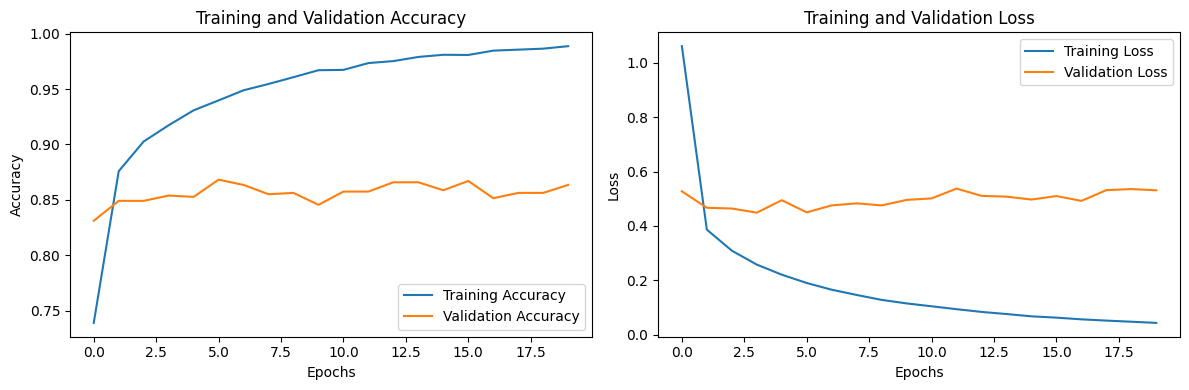

In [28]:
import matplotlib.pyplot as plt

# Graphs for ResNet50 Dog breed model
# Access the training history from the `history` object
Xception_History = XceptionHistory.history

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(Xception_History['accuracy'], label='Training Accuracy')
plt.plot(Xception_History['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(Xception_History['loss'], label='Training Loss')
plt.plot(Xception_History['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

In [30]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 13ms/step
Test accuracy: 85.4067%
